## Getting the data

In [ ]:
import kagglehub
import os
import shutil
# Download latest version
path = kagglehub.dataset_download("carlosgdcj/genius-song-lyrics-with-language-information")
shutil.move(path, r'/kaggle/working/data')


In [2]:
!pip install fireducks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 36.4 MB/s eta 0:00:0000:0100:01


## Imports

In [3]:
import fireducks.pandas as pd
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from tqdm import tqdm


from collections import defaultdict
from collections import Counter
import linecache
import random
import json
import time
import os


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Setting the regular expression

In [4]:
import re

# Compile regex patterns once (faster)
RE_BRACKETS = re.compile(r'\[.*?\]')
RE_NEWLINE = re.compile(r'\n')
RE_MULTISPACE = re.compile(r'\s+')
RE_SPECIAL = re.compile(r'[^a-z0-9\s_]')
RE_EDGE_NEWLINE = re.compile(r'^[\s_newline_\s]*|[_newline_]*$')

def preprocess_text(text):
    text = text.strip().lower()
    text = RE_BRACKETS.sub('', text) # To remove the section titles like [Intro], [Chorus],  ...
    text = RE_NEWLINE.sub(' _newline_ ', text) # To make every song a one line
    text = RE_MULTISPACE.sub(' ', text)
    text = RE_SPECIAL.sub('', text) # To remove any special characters
    text = RE_EDGE_NEWLINE.sub('', text) # Remove _newline_ at the start or end
    return text

In [11]:
# file_path = "english_lyrics.txt"
file_path = "/kaggle/working/english_lyrics.txt"

In [54]:
with open(file_path, "w", encoding="utf-8") as f:
    for chunk in tqdm(pd.read_csv("/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv", usecols=['lyrics', 'language_ft', 'tag'],
                                   dtype={'lyrics': str, 'language_ft': str, 'tag':str}, chunksize=20000,
                                   )):

        filtered = chunk[(chunk['language_ft'] == 'en') & (chunk['tag'] == 'pop')]
        lyrics = filtered['lyrics'].tolist()

        # Batch preprocessing and writing
        processed = [preprocess_text(lyric) for lyric in lyrics]
        f.write('\n'.join(processed) + '\n')


257it [07:00,  1.64s/it]


In [ ]:
!cp english_lyrics.txt drive/MyDrive/

Getting the data already exported to drive

In [2]:
!pip install gdown

In [12]:
!gdown --id 1979eazPZGrI_8Zm8PMe6O8ry4y13kVX9

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1979eazPZGrI_8Zm8PMe6O8ry4y13kVX9

but Gdown can't. Please check connections and permissions.


In [ ]:
!cp drive/MyDrive/english_lyrics.txt english_lyrics.txt

### Building the vocab

In [60]:
def tokenize_and_build_vocab(file_path, min_freq=2, n_songs = 50000):
    n_lines_processed = 0
    vocab_counter = Counter()

    with open(file_path, "r", encoding="utf-8") as f:
        for line in tqdm(f, desc="Tokenizing and Counting"):
            tokens = word_tokenize(line.strip())
            vocab_counter.update(tokens)
            n_lines_processed += 1
            if n_lines_processed >= n_songs:
                break

    # Apply frequency threshold
    vocab = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}

    nex_index = len(vocab)
    for word, freq in vocab_counter.items():
        if freq >= min_freq and word not in vocab:
            vocab[word] = nex_index
            nex_index += 1

    return vocab

vocab50k = tokenize_and_build_vocab(file_path, 3, 5000)

Tokenizing and Counting: 4999it [00:04, 1053.73it/s]


In [62]:
print(f"Vocab size: {len(vocab50k)}")

Vocab size: 11358


Saving the vocab to file 

In [ ]:

with open("vocab50k.json", "w", encoding="utf-8") as f:
    json.dump(vocab50k, f, ensure_ascii=False, indent=2)

In [ ]:


with open("vocab50k.json", "r", encoding="utf-8") as f:
    vocab50k = json.load(f)

## Building The Dataset

In [78]:
class LyricsDataset(Dataset):
    def __init__(self, file_path, vocab, max_input_len=32, max_output_len=64,
                 start_line=0, end_line=50000, training_strategy="sliding_window",
                 sliding_window_size=3, context_length=3):

        self.file_path = file_path
        self.vocab = vocab
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len
        self.start_line = start_line
        self.end_line = min(end_line, self._get_file_line_count())
        self.training_strategy = training_strategy
        self.sliding_window_size = sliding_window_size
        self.context_length = context_length

        # Calculate line offsets for efficient access
        self._calculate_line_offsets()

        # Special tokens
        self.PAD_IDX = vocab.get('<PAD>', 0)
        self.SOS_IDX = vocab.get('<SOS>', 1)
        self.EOS_IDX = vocab.get('<EOS>', 2)
        self.UNK_IDX = vocab.get('<UNK>', 3)
        
        # Track song indices and positions for efficient sampling
        self._build_song_index()

    def _get_file_line_count(self):
        """Get the total number of lines in the file or return a large number if too big"""
        try:
            with open(self.file_path, 'r', encoding='utf-8') as f:
                for i, _ in enumerate(f):
                    pass
            return i + 1
        except:
            # If file is too large, use a conservative estimate
            return float('inf')

    def _calculate_line_offsets(self):
        """Store line offsets for the specified range for efficient random access"""
        self.line_offsets = {}

        # We only need to calculate offsets for the range we'll use
        with open(self.file_path, 'r', encoding='utf-8') as f:
            offset = 0
            for line_idx, line in enumerate(f):
                if line_idx >= self.start_line and line_idx < self.end_line:
                    self.line_offsets[line_idx] = offset
                offset += len(line.encode('utf-8'))  # Account for multi-byte characters

                # Early termination if we've processed enough lines
                if line_idx >= self.end_line:
                    break
    
    def _build_song_index(self):
        """Build an index of songs and their line positions for more efficient sampling"""
        self.song_examples = []
        processed_songs = 0
        valid_songs = 0
        
        for idx in range(self.end_line - self.start_line):
            real_idx = self.start_line + idx
            song_lines = self._get_song_lines(idx)
            processed_songs += 1
            
            # Skip songs that are too short
            if len(song_lines) < 2:
                continue

            valid_songs +=1
            # Create training examples based on strategy
            if self.training_strategy == "sliding_window":
                # Create sliding window examples
                for i in range(len(song_lines) - 1):
                    # Create sliding windows of specified size
                    end_idx = min(i + self.sliding_window_size, len(song_lines))
                    if end_idx - i < 2:  # Need at least 2 lines
                        continue
                        
                    # Store the example
                    self.song_examples.append({
                        'song_idx': idx,
                        'start_line': i,
                        'end_line': end_idx
                    })
            
            elif self.training_strategy == "full_context":
                # For each line (except first), use previous context_length lines as input
                for i in range(1, len(song_lines)):
                    start_idx = max(0, i - self.context_length)
                    # Store the example
                    self.song_examples.append({
                        'song_idx': idx,
                        'context_start': start_idx,
                        'context_end': i,
                        'target_line': i
                    })
            
            elif self.training_strategy == "verse_chorus":
                # Simple heuristic: try to identify repeating sections
                # More sophisticated verse/chorus identification could be implemented
                self._add_verse_chorus_examples(idx, song_lines)

        

    def _add_verse_chorus_examples(self, song_idx, song_lines):
        """Add training examples based on verse/chorus structure"""
        # Simple approach: look for repeated lines that might indicate chorus
        seen_lines = {}
        potential_choruses = []
        
        # Identify potential choruses (repeated lines)
        for i, line in enumerate(song_lines):
            # Normalize the line for comparison
            norm_line = line.lower().strip()
            if len(norm_line) < 5:  # Skip very short lines
                continue
                
            if norm_line in seen_lines:
                potential_choruses.append((seen_lines[norm_line], i))
            else:
                seen_lines[norm_line] = i
        
        # Create examples from verse to chorus transitions
        for verse_idx, chorus_idx in potential_choruses:
            # Use a few lines before chorus as context
            context_start = max(0, verse_idx - 2)
            
            # Add an example leading up to the chorus
            self.song_examples.append({
                'song_idx': song_idx,
                'context_start': context_start,
                'context_end': verse_idx + 1,
                'target_start': chorus_idx,
                'target_end': min(chorus_idx + 2, len(song_lines))
            })
            
        # If no chorus structure found, fall back to sliding window
        if not potential_choruses:
            for i in range(len(song_lines) - 1):
                end_idx = min(i + self.sliding_window_size, len(song_lines))
                if end_idx - i < 2:
                    continue
                    
                self.song_examples.append({
                    'song_idx': song_idx,
                    'start_line': i,
                    'end_line': end_idx
                })

    def _get_song_lines(self, idx):
        """Get all lines from a song by splitting on _newline_"""
        real_idx = self.start_line + idx
        with open(self.file_path, 'r', encoding='utf-8') as f:
            f.seek(self.line_offsets[real_idx])
            song_text = f.readline().strip()

        # Split the song into individual lines
        lines = song_text.split('_newline_')
        return [line.strip() for line in lines if line.strip()]

    def _tokenize(self, text):
        """Tokenize text into tokens and convert to indices"""
        # This assumes you have a word_tokenize function imported
        tokens = text.strip().split()  # Simple space tokenization, replace with better tokenization
        return [self.vocab.get(token, self.UNK_IDX) for token in tokens]

    def __len__(self):
        """Return the number of examples, not the number of songs"""
        return len(self.song_examples)

    def __getitem__(self, idx):
        """Get a training example"""
        example = self.song_examples[idx]
        song_idx = example['song_idx']
        song_lines = self._get_song_lines(song_idx)
        
        if self.training_strategy == "sliding_window":
            # Get the specified window of lines
            start_line = example['start_line']
            end_line = example['end_line']
            
            # Use first n-1 lines as input, last line as target
            input_text = " ".join(song_lines[start_line:end_line-1])
            target_text = song_lines[end_line-1]
            
        elif self.training_strategy == "full_context":
            # Use context lines as input, target line as output
            context_start = example['context_start']
            context_end = example['context_end']
            target_line = example['target_line']
            
            input_text = " ".join(song_lines[context_start:context_end])
            target_text = song_lines[target_line]
            
        elif self.training_strategy == "verse_chorus":
            # Use context as input, target section as output
            context_start = example['context_start']
            context_end = example['context_end']
            target_start = example['target_start']
            target_end = example['target_end']
            
            input_text = " ".join(song_lines[context_start:context_end])
            target_text = " ".join(song_lines[target_start:target_end])
        
        # Tokenize and prepare tensors
        input_tokens = self._tokenize(input_text)
        output_tokens = [self.SOS_IDX] + self._tokenize(target_text) + [self.EOS_IDX]

        # Truncate or pad sequences
        if len(input_tokens) > self.max_input_len:
            input_tokens = input_tokens[:self.max_input_len]
        else:
            # Pad with PAD_IDX
            input_tokens = input_tokens + [self.PAD_IDX] * (self.max_input_len - len(input_tokens))

        if len(output_tokens) > self.max_output_len:
            output_tokens = output_tokens[:self.max_output_len-1] + [self.EOS_IDX]
        else:
            # Pad with PAD_IDX
            output_tokens = output_tokens + [self.PAD_IDX] * (self.max_output_len - len(output_tokens))

        return {
            'input_ids': torch.tensor(input_tokens, dtype=torch.long),
            'target_ids': torch.tensor(output_tokens, dtype=torch.long),
            'input_text': input_text,
            'target_text': target_text
        }


In [124]:
def get_dataloader(file_path, vocab, batch_size=32, num_workers=2,
                   max_input_len = 32, max_output_len=64, training_strategy="sliding_window",
                   start_line=0, end_line=50000, sliding_window_size=3, context_length=3):
    
    dataset = LyricsDataset(file_path, vocab, max_input_len, max_output_len,
                            start_line, end_line, training_strategy,
                            sliding_window_size, context_length)

    return DataLoader(dataset, batch_size=batch_size, shuffle=True,
                      num_workers=num_workers, pin_memory=True)

## Building the model

In [69]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers=1, dropout=0.0):
        super().__init__()
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=dropout if n_layers>1 else 0,
                            batch_first=True, bidirectional = True)

        self.fc = nn.Linear(hidden_dim*2, hidden_dim)

        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, src):
        if self.dropout:
            embedded = self.dropout(self.embedding(src))
        else:
            embedded = self.embedding(src)

        outputs, (hidden, cell) = self.lstm(embedded)

        hidden_forward = hidden[0:self.n_layers, :,:]
        hidden_backward = hidden[self.n_layers:, :,:]
        combined_hidden = torch.cat((hidden_forward, hidden_backward), dim=2)
        transformed_hidden = torch.tanh(self.fc(combined_hidden))

        cell_forward = cell[0:self.n_layers, :, :]
        cell_backward = cell[self.n_layers:, :, :]
        combined_cell = torch.cat((cell_forward, cell_backward), dim=2)
        transformed_cell = torch.tanh(self.fc(combined_cell))


        return outputs, (transformed_hidden, transformed_cell)



In [70]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        if mask is not None:
            attention = attention.masked_fill(mask==0, -1e10)

        return F.softmax(attention, dim=1)

In [71]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, enc_hidden_dim, n_layers=1, dropout=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = Attention(enc_hidden_dim, hidden_dim)

        self.lstm = nn.LSTM(emb_dim + (enc_hidden_dim * 2), hidden_dim, n_layers,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)

        self.fc_out = nn.Linear((enc_hidden_dim *2) + hidden_dim + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, input, hidden, cell, encoder_outputs, mask=None):
        embedded = self.dropout(self.embedding(input)) if self.dropout else self.embedding(input)

        attention_w = self.attention(hidden[-1], encoder_outputs, mask).unsqueeze(1)
        context=torch.bmm(attention_w, encoder_outputs)

        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        context = context.squeeze(1)
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))

        return prediction, hidden, cell, attention_w.squeeze(1)



In [72]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

    def create_mask(self, src):
        mask = (src != self.pad_idx)
        return mask

    def forward(self, src, target, teacher_forcing_ratio=0.5):
        batch_size= src.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        attention_w = torch.zeros(batch_size,target_len, src.shape[1]).to(self.device)

        mask = self.create_mask(src)

        encoder_outputs, (hidden, cell) = self.encoder(src)

        input = target[:,0].unsqueeze(1)

        for t in range(1, target_len):
            output, hidden, cell, attn = self.decoder(input, hidden, cell, encoder_outputs, mask)

            outputs[:, t, :] = output
            attention_w[:, t, :] = attn

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)
            input = target[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        return outputs, attention_w

    def generate(self, src, max_len=50, sos_idx=1, eos_idx=2):
        batch_size = src.shape[0]
        mask = self.create_mask(src)
        encoder_outputs, (hidden, cell) = self.encoder(src)

        generated = torch.full((batch_size, 1), sos_idx, dtype=torch.long).to(self.device)
        input = generated[:, 0].unsqueeze(1)

        attention_history = torch.zeros(batch_size, max_len, src.shape[1]).to(self.device)

        completed = torch.zeros(batch_size, dtype=torch.bool).to(self.device)

        for t in range(1, max_len):
            output, hidden, cell, attention = self.decoder(input, hidden, cell, encoder_outputs, mask)

            top1 = output.argmax(1)
            attention_history[:, t, :] = attention

            input = top1.unsqueeze(1)
            generated = torch.cat((generated, input), dim=1)

            completed = completed | (input == eos_idx)
            if completed.all():
                break

        return generated, attention_history





## Building train and validation loops

In [73]:
def train_epoch(model, dataloader, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(dataloader, desc="Training", unit="batch")

    for batch in progress_bar:
        src = batch['input_ids'].to(device)
        target = batch['target_ids'].to(device)

        optimizer.zero_grad()

        output, _ = model(src, target)

        output_dim = output.shape[-1]
        output = output[:, 1:].contiguous().view(-1, output_dim)
        target = target[:, 1:].contiguous().view(-1)

        loss = criterion(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(dataloader)

In [39]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src = batch['input_ids'].to(device)
            target = batch['target_ids'].to(device)

            output, _ = model(src, target, teacher_forcing_ratio=0)

            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            target = target[:, 1:].contiguous().view(-1)

            loss = criterion(output, target)

            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)



In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs,
                clip, device, checkpoint_dir='checkpoints', patience=5):

    os.makedirs(checkpoint_dir, exist_ok=True)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip, device)
        val_loss = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Print progress
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {val_loss:.3f}')

        # Save checkpoint if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0

            # Save with dictionary structure
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, os.path.join(checkpoint_dir, 'best_model.pt'))
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement')
            break

    plot_losses(train_losses, val_losses, checkpoint_dir)

    # Load the best model
    checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, train_losses, val_losses



In [41]:
def plot_losses(train_losses, val_losses, checkpoint_dir):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation losses')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(checkpoint_dir, 'losses.png'))
    plt.show()

In [42]:
def generate_lyrics(model, input_text, vocab, idx_to_word, device, max_len=50):
    model.eval()
    input_text = preprocess_text(input_text)
    tokens = word_tokenize(input_text.strip())
    token_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    src = torch.tensor([token_ids]).to(device)

    with torch.no_grad():
        generated_ids, attention = model.generate(src, max_len=max_len)

    generated_tokens = []
    eos_idx = vocab.get('<EOS>', 2)

    for idx in generated_ids[0, 1:]:
        if idx.item() == eos_idx:
            break

        generated_tokens.append(idx_to_word.get(idx.item(), '<UNK>'))
    return ' '.join(generated_tokens)

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def initialize_model(input_dim, output_dim, emb_dim, hidden_dim, n_layers=1, dropout = 0, device=device):
    encoder = Encoder(input_dim, emb_dim, hidden_dim, n_layers, dropout)

    decoder = Decoder(output_dim, emb_dim, hidden_dim, hidden_dim, n_layers, dropout)

    model = Seq2Seq(encoder, decoder, device, pad_idx=0)

    def init_weights(m):
        if isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)
                    # Set forget gate bias to 1
                    n = param.size(0)
                    start, end = n // 4, n // 2
                    param.data[start:end].fill_(1.)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight.data, mean=0, std=0.01)

    model.apply(init_weights)

    return model.to(device)




In [125]:
file_path=file_path
embedding_dim=128
hidden_dim=128
n_layers=4
dropout=0.3
batch_size=64
num_workers=2
learning_rate=0.0001
n_epochs=3
clip=1.0
patience=5
train_size=1000
val_size=500
max_input_len=32
max_output_len=64
checkpoint_dir='checkpoints'
device='cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

# Load vocabulary
print("Loading vocabulary...")
# vocab = torch.load('vocab.pth')
vocab = vocab50k
# Create index to word mapping
idx_to_word = {idx: word for word, idx in vocab.items()}

# Get vocabulary size
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Create dataloaders
print("Creating dataloaders...")

train_loader = get_dataloader(
    file_path=file_path,
    vocab=vocab,
    batch_size=batch_size,
    num_workers=num_workers,
    max_input_len=max_input_len,
    max_output_len=max_output_len,
    start_line=0,
    end_line=train_size
)

val_loader = get_dataloader(
    file_path=file_path,
    vocab=vocab,
    batch_size=batch_size,
    num_workers=num_workers,
    max_input_len=max_input_len,
    max_output_len=max_output_len,
    start_line=0,
    end_line=val_size
)

Using device: cuda
Loading vocabulary...
Vocabulary size: 11358
Creating dataloaders...


In [126]:
# Initialize model
print("Initializing model...")

model = initialize_model(
    input_dim=vocab_size,
    output_dim=vocab_size,
    emb_dim=embedding_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    dropout=dropout,
    device=device
)

# Print model summary
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

# Initialize optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Ignore padding index in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<PAD>'])



Initializing model...
Model has 10,926,046 trainable parameters


Sanity check to make sure the model is working fine

In [127]:
idx_to_word = {idx: word for word, idx in vocab50k.items()}

print("\nGenerating sample lyrics...")

sample_inputs = [
    "I could make you happy",
    "The sun sets over the horizon",
    "Love is like a river flowing"
]

for input_text in sample_inputs:
    print(f"\nInput: {input_text}")
    generated = generate_lyrics(model, input_text, vocab50k, idx_to_word, device)
    print(f"Generated: {generated}")

print("\nTraining complete!")


Generating sample lyrics...

Input: I could make you happy
Generated: charity ribs fbi funk interminable hymn accept spanish actress snowed stretching nowadays torn coca dope brings legacy darkest cinderellas author gentle motto jail baseball throws welles desperately spree enticing widest crack trumpets hawaii holdin hummingbird lightning sort muvete holdin hummingbird lightning holdin hummingbird lightning holdin hummingbird lightning holdin hummingbird

Input: The sun sets over the horizon
Generated: laces desserts skips leaning pleasures alongside persona whatwhat book tube portion um means creep richer wonton lawns dedication kicking lookie wrapping wawawawatch lovers reverie sleeps forever pumpin suck shudder keenna woulda meth shudder keenna woulda bella hang heyyeah notch motion fountain scarface moving ringtone ringtone ringtone ringtone ringtone ringtone

Input: Love is like a river flowing
Generated: charity ribs neighbourhood tricks streak expose riding 21st over whyyiyiyi

Training model...


Evaluating: 100%|██████████| 470/470 [01:07<00:00,  6.93it/s]


Epoch: 01 | Time: 6m 12s
	Train Loss: 5.953 | Val. Loss: 5.681


Evaluating: 100%|██████████| 470/470 [01:07<00:00,  6.99it/s]


Epoch: 02 | Time: 6m 12s
	Train Loss: 5.599 | Val. Loss: 5.630


Evaluating: 100%|██████████| 470/470 [01:07<00:00,  6.99it/s]


Epoch: 03 | Time: 6m 12s
	Train Loss: 5.499 | Val. Loss: 5.579


Evaluating: 100%|██████████| 470/470 [01:07<00:00,  6.99it/s]


Epoch: 04 | Time: 6m 12s
	Train Loss: 5.425 | Val. Loss: 5.545


Evaluating: 100%|██████████| 470/470 [01:10<00:00,  6.69it/s]


Epoch: 05 | Time: 6m 15s
	Train Loss: 5.362 | Val. Loss: 5.517


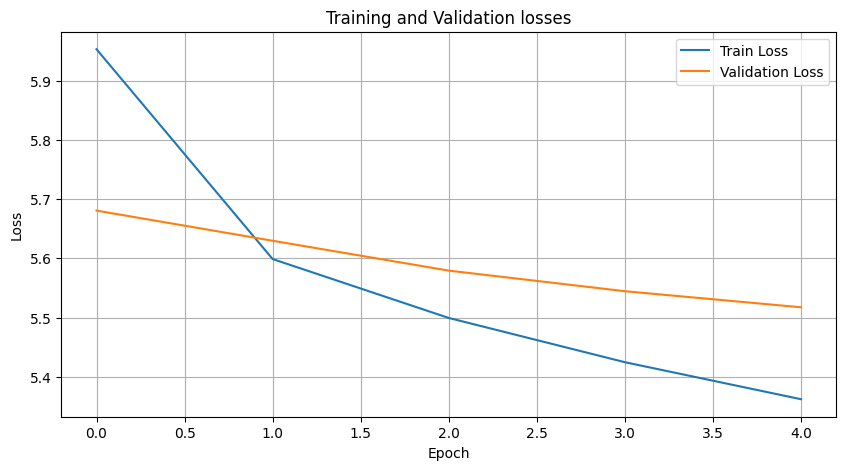

In [128]:
# Train model
print("Training model...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=5,
    clip=clip,
    device=device,
    checkpoint_dir=checkpoint_dir,
    patience=patience
)


Training model...


Evaluating: 100%|██████████| 470/470 [01:21<00:00,  5.80it/s]


Epoch: 01 | Time: 6m 26s
	Train Loss: 5.131 | Val. Loss: 5.388


Evaluating: 100%|██████████| 470/470 [01:21<00:00,  5.75it/s]


Epoch: 02 | Time: 6m 27s
	Train Loss: 5.097 | Val. Loss: 5.367


Evaluating: 100%|██████████| 470/470 [01:21<00:00,  5.77it/s]


Epoch: 03 | Time: 6m 26s
	Train Loss: 5.062 | Val. Loss: 5.341


Evaluating: 100%|██████████| 470/470 [01:20<00:00,  5.83it/s]


Epoch: 04 | Time: 6m 26s
	Train Loss: 5.036 | Val. Loss: 5.321


Evaluating: 100%|██████████| 470/470 [01:45<00:00,  4.47it/s]


Epoch: 05 | Time: 7m 17s
	Train Loss: 5.000 | Val. Loss: 5.312


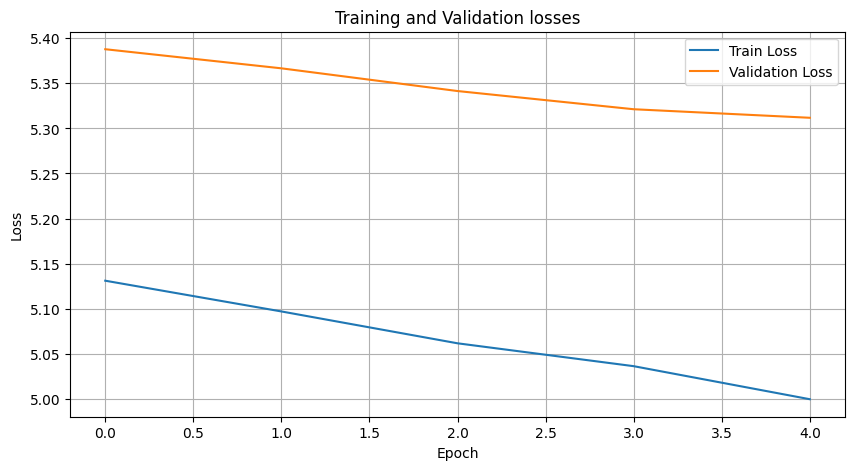

In [132]:
# Train model
print("Training model...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=5,
    clip=clip,
    device=device,
    checkpoint_dir=checkpoint_dir,
    patience=patience
)


Training model...


Evaluating: 100%|██████████| 470/470 [01:45<00:00,  4.47it/s]


Epoch: 01 | Time: 7m 59s
	Train Loss: 4.976 | Val. Loss: 5.285


Evaluating: 100%|██████████| 470/470 [01:45<00:00,  4.46it/s]


Epoch: 02 | Time: 7m 59s
	Train Loss: 4.944 | Val. Loss: 5.257


Evaluating: 100%|██████████| 470/470 [01:45<00:00,  4.46it/s]


Epoch: 03 | Time: 7m 59s
	Train Loss: 4.910 | Val. Loss: 5.230


Evaluating: 100%|██████████| 470/470 [01:45<00:00,  4.45it/s]


Epoch: 04 | Time: 8m 0s
	Train Loss: 4.885 | Val. Loss: 5.220


Evaluating: 100%|██████████| 470/470 [01:45<00:00,  4.47it/s]


Epoch: 05 | Time: 7m 59s
	Train Loss: 4.865 | Val. Loss: 5.188


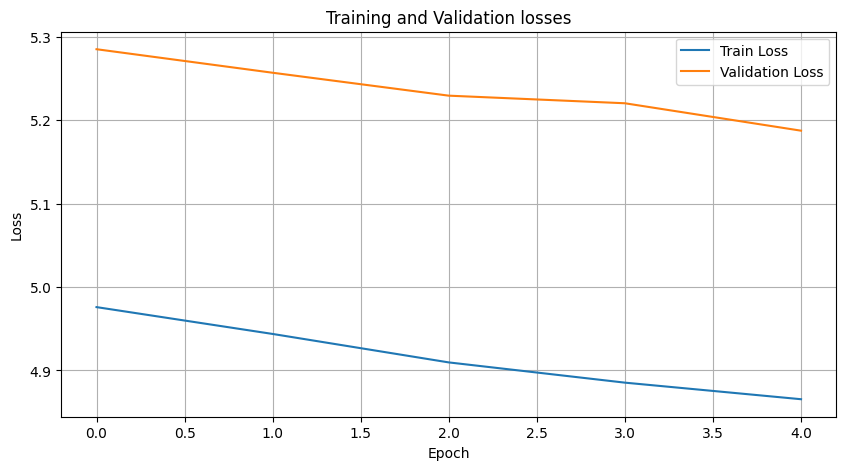

In [134]:
# Train model
print("Training model...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=5,
    clip=clip,
    device=device,
    checkpoint_dir=checkpoint_dir,
    patience=patience
)


In [133]:
idx_to_word = {idx: word for word, idx in vocab50k.items()}

print("\nGenerating sample lyrics...")

sample_inputs = [
    "cuz we get it in you know the girls bring the boys out' ",
    "The sun sets over the horizon",
    "aaaaaa"]

for input_text in sample_inputs:
    print(f"\nInput: {input_text}")
    generated = generate_lyrics(model, input_text, vocab50k, idx_to_word, device)
    print(f"Generated: {generated}")



Generating sample lyrics...

Input: cuz we get it in you know the girls bring the boys out' 
Generated: <UNK> the the the the <UNK>

Input: The sun sets over the horizon
Generated: be a little heart

Input: aaaaaa
Generated: be a little body
